#### imports

In [1]:
import os
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import shutil
import random
from collections import Counter
from PIL import Image
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as T
from torchvision.transforms import functional as TF
from tqdm import tqdm
from torchvision import datasets
from torch.utils.data import DataLoader

import torch
import torch.nn as nn
# import torch.nn.functional as F
import torch.optim as optim
from torchvision.models import mobilenet_v2
from torch.optim.lr_scheduler import StepLR

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# CV Project: Classification of drone types by images

#### This project focuses on building a convolutional neural network (CNN) model for classifying images based on the presence and type of drone.

The model is trained to recognize four classes:
- **no_drone** – images without any drone
- **dji_mavic**
- **dji_phantom**
- **dji_inspire**

#### Dataset source:

https://www.kaggle.com/datasets/balajikartheek/drone-type-classification

#### Project objective:

Develop a strong image classifier for drone detection and type identification.

#### Author: Mariia Cherkasova

# dataset overview

## folder structure & images overview

### folder

In [3]:
ds_path = '/kaggle/input/drone-type-classification/Synthetic_Drone_Classification_Dataset'

In [4]:
train_path = '/kaggle/input/drone-type-classification/Synthetic_Drone_Classification_Dataset/train'
val_path = '/kaggle/input/drone-type-classification/Synthetic_Drone_Classification_Dataset/val'

- whole folder

In [5]:
print(f'Sctucture {ds_path}:')
for item in os.listdir(ds_path):
  print(item)

Sctucture /kaggle/input/drone-type-classification/Synthetic_Drone_Classification_Dataset:
val
train


- train folder

In [6]:
print(f'Sctucture {train_path}:')
for item in os.listdir(train_path):
  print(item)

Sctucture /kaggle/input/drone-type-classification/Synthetic_Drone_Classification_Dataset/train:
dji_inspire
dji_mavic
no_drone
dji_phantom


- validation folder

In [7]:
print(f'Sctucture {val_path}:')
for item in os.listdir(val_path):
  print(item)

Sctucture /kaggle/input/drone-type-classification/Synthetic_Drone_Classification_Dataset/val:
dji_inspire
dji_mavic
no_drone
dji_phantom


as we can see, there's 4 classes in our dataset and it's already splitted for train and validation.

### images info

- data type

In [8]:
train_png = 0
train_other = 0
val_png = 0
val_other = 0

In [9]:
for class_name in os.listdir(train_path):
    class_dir = os.path.join(train_path, class_name)
    if not os.path.isdir(class_dir):
        continue

    for fname in os.listdir(class_dir):
        if fname.lower().endswith('.png'):
            train_png += 1
        else:
            train_other += 1

for class_name in os.listdir(val_path):
    class_dir = os.path.join(val_path, class_name)
    if not os.path.isdir(class_dir):
        continue

    for fname in os.listdir(class_dir):
        if fname.lower().endswith('.png'):
            val_png += 1
        else:
            val_other += 1

In [10]:
fig = make_subplots(rows=1, cols=2, subplot_titles=("Train", "Validation"))
# train
fig.add_trace(
    go.Bar(x=['PNG', 'Other'], y=[train_png, train_other], name='Train'),
    row=1, col=1)
# val
fig.add_trace(
    go.Bar(x=['PNG', 'Other'], y=[val_png, val_other], name='Val'),
    row=1, col=2)
fig.update_layout(
    title_text='type of images (Train & Validation samples)',
    showlegend=False,
    height=400,
    width=800)
fig.update_yaxes(title_text="num", row=1, col=1)
fig.update_yaxes(title_text="num", row=1, col=2)
fig.show()

all images are PNG! so we won't do anything with data type.

- image format

In [11]:
image_sizes = set()

for folder in [train_path, val_path]:
    for class_name in os.listdir(folder):
        class_dir = os.path.join(folder, class_name)
        if not os.path.isdir(class_dir):
            continue
        for fname in os.listdir(class_dir):
            file_path = os.path.join(class_dir, fname)
            img = Image.open(file_path)
            image_sizes.add(img.size)

In [12]:
if len(image_sizes) == 1:
    print('all images have the same size', list(image_sizes)[0])
else:
    print('different image size:', image_sizes)

different image size: {(1901, 1080), (451, 451), (267, 267), (1243, 1080), (277, 277), (61, 61), (543, 543), (181, 181), (369, 369), (153, 153), (273, 273), (57, 57), (429, 429), (117, 117), (365, 365), (149, 149), (953, 953), (305, 305), (425, 425), (209, 209), (241, 241), (613, 613), (397, 397), (35, 35), (517, 517), (301, 301), (705, 705), (127, 127), (393, 393), (403, 403), (297, 297), (435, 435), (91, 91), (339, 339), (123, 123), (485, 485), (495, 495), (279, 279), (389, 389), (605, 605), (399, 399), (183, 183), (63, 63), (431, 431), (215, 215), (977, 977), (587, 587), (371, 371), (491, 491), (275, 275), (59, 59), (1631, 1080), (101, 101), (367, 367), (377, 377), (271, 271), (643, 643), (65, 65), (675, 675), (459, 459), (97, 97), (579, 579), (363, 363), (253, 253), (373, 373), (157, 157), (189, 189), (561, 561), (345, 345), (827, 827), (465, 465), (249, 249), (33, 33), (1331, 1080), (1463, 1080), (919, 919), (557, 557), (341, 341), (125, 125), (245, 245), (29, 29), (617, 617), (40

there's lots of different image sizes, let's visualize it.

In [13]:
widths = []
heights = []
labels = []

for folder, label in [(train_path, 'train'), (val_path, 'val')]:
    for class_name in os.listdir(folder):
        class_dir = os.path.join(folder, class_name)
        if not os.path.isdir(class_dir):
            continue
        for fname in os.listdir(class_dir):
            file_path = os.path.join(class_dir, fname)
            img = Image.open(file_path)
            w, h = img.size
            widths.append(w)
            heights.append(h)
            labels.append(label)

In [14]:
fig = px.scatter(
    x=widths,
    y=heights,
    color=labels,
    labels={'x': 'width', 'y': 'height'},
    title='image size distribution (Train & Validation samples)',)

fig.update_traces(marker=dict(size=6, opacity=0.6))
fig.update_layout(width=800, height=500)
fig.show()

most of images - squares, but not all of them. so we should definitely work on it

## class

let's see if the dataset is balanced by class.

In [15]:
def count_img(path):
    counts = {}
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        if os.path.isdir(folder_path) and not folder.startswith('.'):
            counts[folder] = len(os.listdir(folder_path))
    return counts

In [16]:
train_counts = count_img(train_path)
val_counts = count_img(val_path)

df_train = pd.DataFrame(list(train_counts.items()), columns=['class', 'count'])
df_val = pd.DataFrame(list(val_counts.items()), columns=['class', 'count'])

In [17]:
fig = make_subplots(rows=1, cols=2, subplot_titles=('Train', 'Validation'))

fig.add_trace(
    go.Bar(x=df_train['class'], y=df_train['count'], text=df_train['count'],
           name='Train'), row=1, col=1)

fig.add_trace(
    go.Bar(x=df_val['class'], y=df_val['count'], text=df_val['count'],
           name='Val', marker_color='#9467bd'), row=1, col=2)

fig.update_layout(
    title_text='num of images in each class (Train & Validation samples)',
    width=1000, height=500, showlegend=False)

fig.update_xaxes(title_text='class', tickangle=-45, row=1, col=1)
fig.update_xaxes(title_text='class', tickangle=-45, row=1, col=2)
fig.update_yaxes(title_text='num', row=1, col=1)
fig.update_yaxes(title_text='num', row=1, col=2)
fig.show()

so there's ~1000 per each class for both train and validation datasets.

perfect!

## train/val/test split

we already got train set with 4000 samples and validation set with 4000 samples.

let's make test and validation samples 50/50, we'll have 2000 samples for validation and 2000 samples for test.

In [18]:
paths_to_remove = ['/kaggle/working/val', '/kaggle/working/test']

for path in paths_to_remove:
    if os.path.exists(path):
        shutil.rmtree(path)

In [19]:
test_path = '/kaggle/working/test'
val_path = '/kaggle/working/val'
val_path1 = '/kaggle/input/drone-type-classification/Synthetic_Drone_Classification_Dataset/val'

In [20]:
for cls in os.listdir(val_path1):
    src = os.path.join(val_path1, cls)
    if not os.path.isdir(src):
        continue

    dst_val = os.path.join(val_path, cls)
    dst_test = os.path.join(test_path, cls)

    os.makedirs(dst_val, exist_ok=True)
    os.makedirs(dst_test, exist_ok=True)

    files = os.listdir(src)
    random.shuffle(files)

    split_idx = len(files) // 2
    val_files = files[:split_idx]
    test_files = files[split_idx:]

    for f in val_files:
        shutil.copy(os.path.join(src, f), os.path.join(dst_val, f))

    for f in test_files:
        shutil.copy(os.path.join(src, f), os.path.join(dst_test, f))

done!

In [21]:
test_counts = count_img(test_path)
val_counts = count_img(val_path)

df_test = pd.DataFrame(list(test_counts.items()), columns=['class', 'count'])
df_val = pd.DataFrame(list(val_counts.items()), columns=['class', 'count'])

In [22]:
fig = make_subplots(rows=1, cols=2, subplot_titles=('Test', 'Validation'))

fig.add_trace(
    go.Bar(x=df_train['class'], y=df_test['count'], text=df_test['count'],
           name='Test'), row=1, col=1)

fig.add_trace(
    go.Bar(x=df_val['class'], y=df_val['count'], text=df_val['count'],
           name='Val', marker_color='#9467bd'), row=1, col=2)

fig.update_layout(
    title_text='num of images in each class (Test & Validation samples)',
    width=1000, height=500, showlegend=False)

fig.update_xaxes(title_text='class', tickangle=-45, row=1, col=1)
fig.update_xaxes(title_text='class', tickangle=-45, row=1, col=2)
fig.update_yaxes(title_text='num', row=1, col=1)
fig.update_yaxes(title_text='num', row=1, col=2)
fig.show()

done!

# preparing the data

## images

first of all let's take a look on what images we're working with.

### train samples

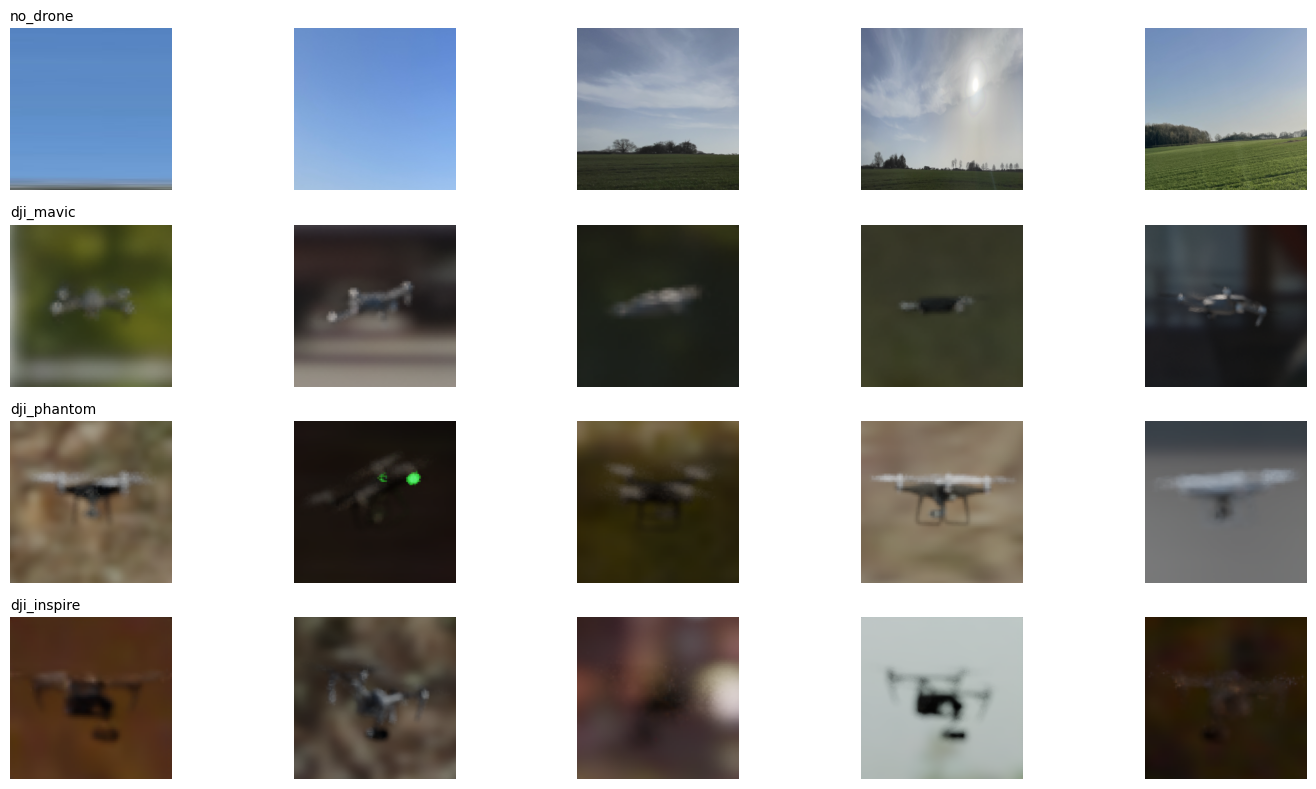

In [23]:
class_names = ['no_drone', 'dji_mavic', 'dji_phantom', 'dji_inspire']

fig, axes = plt.subplots(nrows=len(class_names), ncols=5, figsize=(15, 8))
for i, class_name in enumerate(class_names):
    class_dir = os.path.join(train_path, class_name)
    image_files = [
        f for f in os.listdir(class_dir)
        if os.path.isfile(os.path.join(class_dir, f))]
    random_images = random.sample(image_files, k=5)
    for j, image_name in enumerate(random_images):
        image_path = os.path.join(class_dir, image_name)
        img = Image.open(image_path)
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        if j == 0:
            axes[i, j].set_title(class_name, fontsize=10, loc='left')
plt.tight_layout()
plt.show()

### validation samples

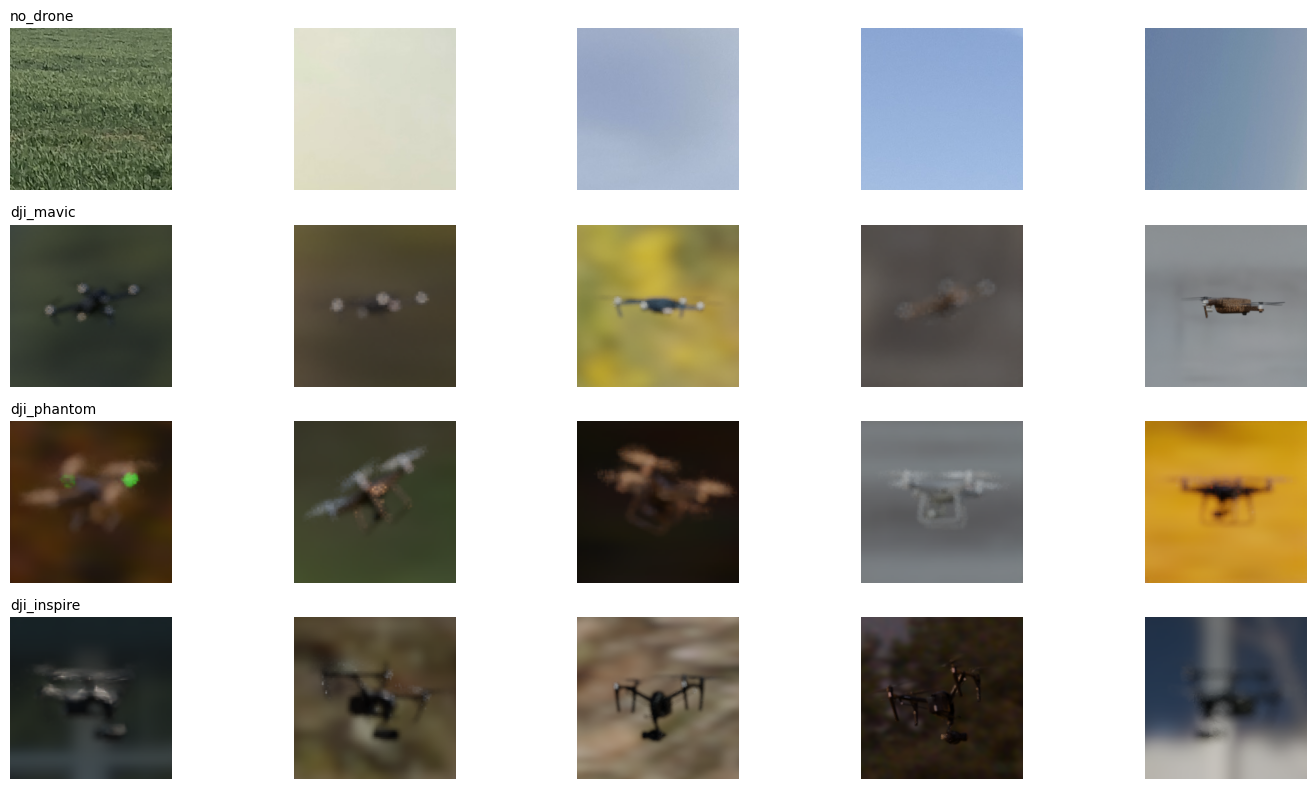

In [24]:
fig, axes = plt.subplots(nrows=len(class_names), ncols=5, figsize=(15, 8))
for i, class_name in enumerate(class_names):
    class_dir = os.path.join(val_path, class_name)
    image_files = [
        f for f in os.listdir(class_dir)
        if os.path.isfile(os.path.join(class_dir, f))]
    random_images = random.sample(image_files, k=5)
    for j, image_name in enumerate(random_images):
        image_path = os.path.join(class_dir, image_name)
        img = Image.open(image_path)
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        if j == 0:
            axes[i, j].set_title(class_name, fontsize=10, loc='left')
plt.tight_layout()
plt.show()

### test samples

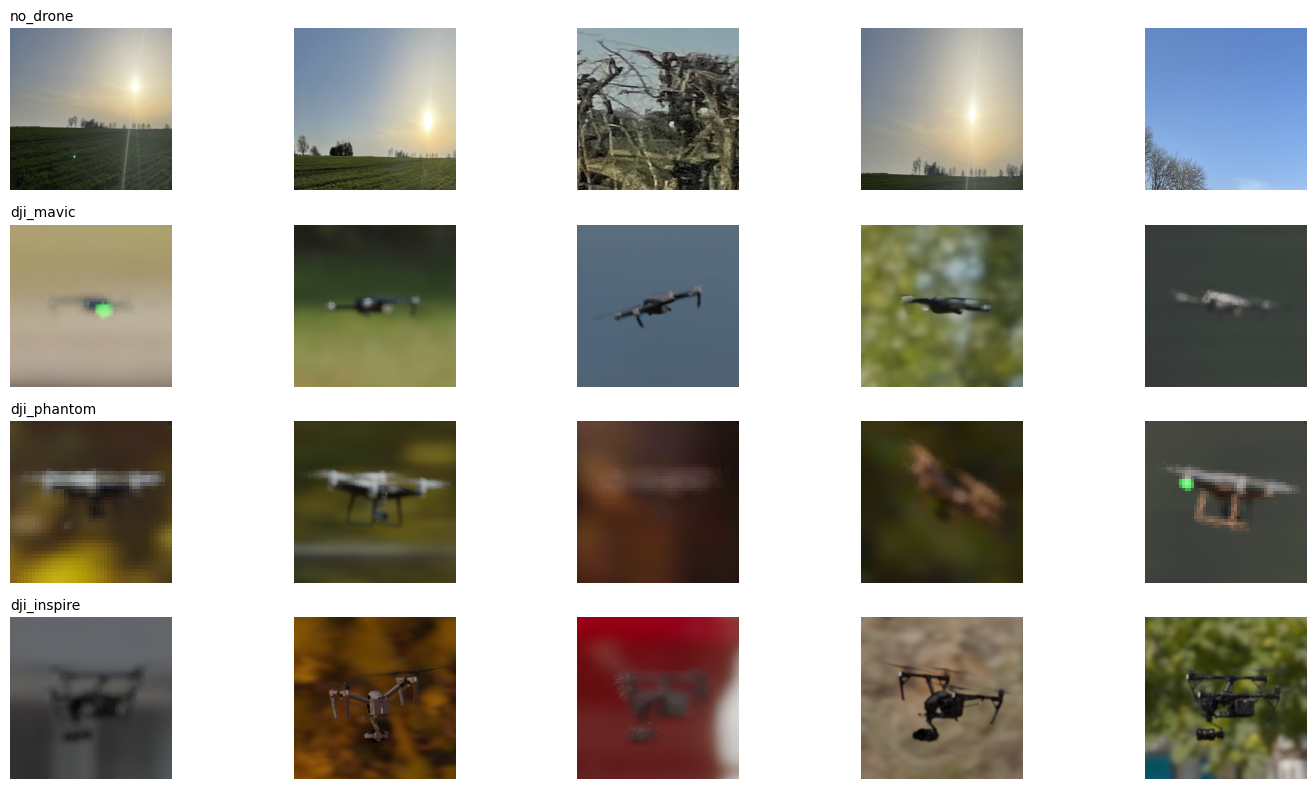

In [25]:
fig, axes = plt.subplots(nrows=len(class_names), ncols=5, figsize=(15, 8))
for i, class_name in enumerate(class_names):
    class_dir = os.path.join(test_path, class_name)
    image_files = [
        f for f in os.listdir(class_dir)
        if os.path.isfile(os.path.join(class_dir, f))]
    random_images = random.sample(image_files, k=5)
    for j, image_name in enumerate(random_images):
        image_path = os.path.join(class_dir, image_name)
        img = Image.open(image_path)
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        if j == 0:
            axes[i, j].set_title(class_name, fontsize=10, loc='left')
plt.tight_layout()
plt.show()

We definitely can work with these images.

I was thinking if augmentation is worth using, cause we already got so many blurred images, and decides that we do need augmentation — but wisely, taking into account the characteristics of the dataset.

## padding

going back to the problem with different size of images. we got:
1.  square images but different sizes (60x60, 500x500 etc)
2. images with different width&height (1400x1080, 1500x1080)

In [26]:
def pad_to_square(img, fill=127):
    w, h = img.size
    if w == h:
        return img
    max_wh = max(w, h)
    pad_left = (max_wh - w) // 2
    pad_top = (max_wh - h) // 2
    pad_right = max_wh - w - pad_left
    pad_bottom = max_wh - h - pad_top
    return TF.pad(img, (pad_left, pad_top, pad_right, pad_bottom), fill=fill)

cheking if everything's working fine

In [27]:
image_path = '/kaggle/input/drone-type-classification/Synthetic_Drone_Classification_Dataset/train/dji_mavic/245.png'

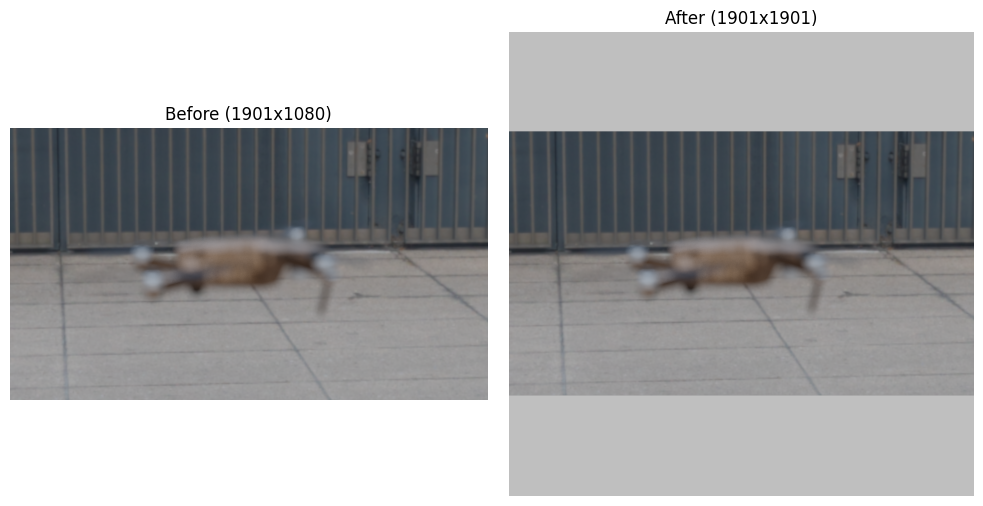

In [28]:
img = Image.open(image_path)
img_padded = pad_to_square(img)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img)
axes[0].set_title(f"Before ({img.size[0]}x{img.size[1]})")
axes[0].axis('off')
axes[1].imshow(img_padded)
axes[1].set_title(f"After ({img_padded.size[0]}x{img_padded.size[1]})")
axes[1].axis('off')

plt.tight_layout()
plt.show()

cool! let's pad other images.

*saving padded dataset separately from original.

In [29]:
src_train = '/kaggle/input/drone-type-classification/Synthetic_Drone_Classification_Dataset/train'
train_path = '/kaggle/working/train'

if os.path.exists(train_path):
    shutil.rmtree(train_path)

shutil.copytree(src_train, train_path)

'/kaggle/working/train'

In [30]:
ds_path = '/kaggle/working/'
p_ds_path = '/kaggle/working/ds_padded'
subfolders = ['train', 'val', 'test']

done!

In [31]:
for split in subfolders:
    split_dir = os.path.join(ds_path, split)
    save_split_dir = os.path.join(p_ds_path, split)
    os.makedirs(save_split_dir, exist_ok=True)

    for class_name in os.listdir(split_dir):
        class_dir = os.path.join(split_dir, class_name)
        if not os.path.isdir(class_dir):
            continue
        save_class_dir = os.path.join(save_split_dir, class_name)
        os.makedirs(save_class_dir, exist_ok=True)

        for fname in tqdm(os.listdir(class_dir), desc=f"{split}/{class_name}"):
            src_path = os.path.join(class_dir, fname)
            dst_path = os.path.join(save_class_dir, fname)
            img = Image.open(src_path)
            img_padded = pad_to_square(img)
            img_padded.save(dst_path)

test/no_drone: 100%|██████████| 500/500 [00:09<00:00, 51.02it/s]


let's give credit to this tqdm progress animation for keeping me from getting nervous!

now let's make sure that all images are squared.

In [32]:
widths = []
heights = []
labels = []

for split in subfolders:
    split_path = os.path.join(p_ds_path, split)
    for class_name in os.listdir(split_path):
        class_dir = os.path.join(split_path, class_name)
        if not os.path.isdir(class_dir):
            continue
        for fname in os.listdir(class_dir):
            file_path = os.path.join(class_dir, fname)
            img = Image.open(file_path)
            w, h = img.size
            widths.append(w)
            heights.append(h)
            labels.append(split)

In [33]:
fig = px.scatter(
    x=widths,
    y=heights,
    color=labels,
    labels={'x': 'width', 'y': 'height'},
    title='image size distribution (ds_padded — Train & Val & Test)',)

fig.update_traces(marker=dict(size=6, opacity=0.6))
fig.update_layout(width=800, height=800)
fig.show()

perfect!

## transforming to tesnor

In [34]:
train_path = '/kaggle/working/ds_padded/train'
val_path = '/kaggle/working/ds_padded/val'
test_path = '/kaggle/working/ds_padded/test'

I decided to add noise, cause it would be much closer to real life, when the drone video transmitter gives a grainy image

In [35]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.05):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        noise = torch.randn(tensor.size()) * self.std + self.mean
        noisy_tensor = tensor + noise
        return torch.clamp(noisy_tensor, 0., 1.)

    def __repr__(self):
        return self.__class__.__name__ + f'(mean={self.mean}, std={self.std})'

In [36]:
train_transform = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    T.RandomRotation(10),
    T.ToTensor(),
    AddGaussianNoise(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])])

In [37]:
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    AddGaussianNoise(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])])

In [38]:
train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
val_dataset   = datasets.ImageFolder(val_path, transform=transform)
test_dataset  = datasets.ImageFolder(test_path, transform=transform)

In [39]:
print('train dataset:      ', len(train_dataset))
print('validation dataset: ', len(val_dataset))
print('test dataset:       ', len(test_dataset))

train dataset:       4001
validation dataset:  2000
test dataset:        2000


images after augmentation:

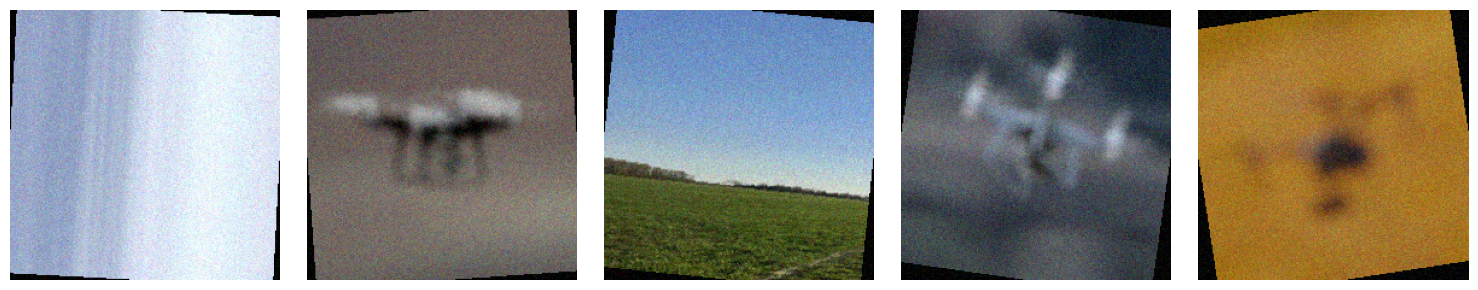

In [40]:
plt.figure(figsize=(15, 3))
random_indices = random.sample(range(len(train_dataset)), 5)

for i, idx in enumerate(random_indices):
    img_path = train_dataset.samples[idx][0]
    orig_img = Image.open(img_path).convert("RGB")
    aug_img = train_transform(orig_img)
    img_np = aug_img.permute(1, 2, 0).numpy()
    img_np = img_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    img_np = img_np.clip(0, 1)
    plt.subplot(1, 5, i+1)
    plt.imshow(img_np)
    plt.axis('off')

plt.tight_layout()
plt.show()

Now let's create DataLoader.

- breaks data into batches
- shuffles data for train, so that the model does not overtrain
- feeds data when needed, not all at once into memory
- feeds tensors already processed by transforms

In [41]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [42]:
print('num of batches in train loader:      ', len(train_loader))
print('num of batches in validation loader: ', len(val_loader))
print('num of batches in test loader:       ', len(test_loader))

num of batches in train loader:       126
num of batches in validation loader:  63
num of batches in test loader:        63


# pre-trained model

## choosing the model

When I trained my own model, it was overfitted, so from that I made a conclusion that I definetly don't need 'heavy' models for this task. 

I chose **MobileNetV2** for this dataset, cause we don't have lots of data (8K images) and we also have just 44 classes, so I think this model shouldn't overfit comparing to other 3 options (ResNet, InceptionV3, Xception)

### importing model

In [43]:
model = mobilenet_v2(weights=None)
state_dict = torch.load('/kaggle/input/mobilenetv2/pytorch/default/1/mobilenet_v2-7ebf99e0.pth', weights_only=True)
model.load_state_dict(state_dict)

<All keys matched successfully>

### adapting model to the dataset

In [44]:
model.classifier[0] = nn.Dropout(p=0.3)

In [45]:
model.classifier[1] = nn.Linear(model.last_channel, 4)

model's structure:

In [46]:
print(model)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

## training

- freezing all convolutional layers

In [47]:
for param in model.features.parameters():
    param.requires_grad = False

In [48]:
model = model.to(device)

- function for unfreezing model's layers

In [49]:
def unfreeze(model, epoch, total_layers):
    target_layer = max(0, total_layers - 1 - epoch)
    for i in range(target_layer, total_layers):
        for param in model.features[i].parameters():
            param.requires_grad = True

- parameters

In [50]:
criterion = nn.CrossEntropyLoss()
# optimizing only unfrozen layers
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,mode='min',factor=0.5, patience=3)

- training

In [51]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, total_layers=19, num_epochs=40):
    # for saving best model
    best_val_acc = 0.0
    best_model_wts = None
    # for progress plot
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for param in model.features.parameters():
        param.requires_grad = False
    
    for epoch in range(num_epochs):

        if epoch > 1:
            unfreeze(model, epoch, total_layers)
            
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            preds = outputs.argmax(dim=1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)

        train_acc = train_correct / train_total
        avg_train_loss = train_loss / len(train_loader)
        train_accuracies.append(train_acc)
        train_losses.append(avg_train_loss)

        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = outputs.argmax(dim=1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_acc = val_correct / val_total
        avg_val_loss = val_loss / len(val_loader)
        val_accuracies.append(val_acc)
        val_losses.append(avg_val_loss)
        scheduler.step(avg_val_loss)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = model.state_dict().copy()

        print(f'EPOCH [{epoch+1}/{num_epochs}]')
        print(f'train loss: {avg_train_loss:.4f} | train accuracy: {train_acc:.4f}')
        print(f'val loss:   {avg_val_loss:.4f}   | val accuracy:   {val_acc:.4f}')

    model.load_state_dict(best_model_wts)
    print(f'\ntraining done. best validation accuracy: {best_val_acc:.4f}')
    
    epochs = list(range(1, num_epochs + 1))
    # loss
    fig_loss = go.Figure()
    fig_loss.add_trace(go.Scatter(x=epochs, y=train_losses, mode='lines+markers', name='Train Loss'))
    fig_loss.add_trace(go.Scatter(x=epochs, y=val_losses, mode='lines+markers', name='Val Loss'))
    fig_loss.update_layout(title='Training vs Validation Loss', xaxis_title='Epoch', yaxis_title='Loss')
    fig_loss.show()
    # accuracy
    fig_acc = go.Figure()
    fig_acc.add_trace(go.Scatter(x=epochs, y=train_accuracies, mode='lines+markers', name='Train Accuracy'))
    fig_acc.add_trace(go.Scatter(x=epochs, y=val_accuracies, mode='lines+markers', name='Val Accuracy'))
    fig_acc.update_layout(title='Training vs Validation Accuracy', xaxis_title='Epoch', yaxis_title='Accuracy')
    fig_acc.show()

In [52]:
train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device)

EPOCH [1/40]
train loss: 1.2689 | train accuracy: 0.4729
val loss:   1.2091   | val accuracy:   0.5345
EPOCH [2/40]
train loss: 1.0896 | train accuracy: 0.6248
val loss:   1.1210   | val accuracy:   0.5605
EPOCH [3/40]
train loss: 0.9867 | train accuracy: 0.6623
val loss:   1.0511   | val accuracy:   0.5980
EPOCH [4/40]
train loss: 0.9199 | train accuracy: 0.6846
val loss:   0.9951   | val accuracy:   0.5895
EPOCH [5/40]
train loss: 0.8715 | train accuracy: 0.6958
val loss:   0.9716   | val accuracy:   0.6025
EPOCH [6/40]
train loss: 0.8265 | train accuracy: 0.7103
val loss:   0.9399   | val accuracy:   0.6330
EPOCH [7/40]
train loss: 0.8071 | train accuracy: 0.7078
val loss:   0.9197   | val accuracy:   0.6270
EPOCH [8/40]
train loss: 0.7700 | train accuracy: 0.7248
val loss:   0.9061   | val accuracy:   0.6305
EPOCH [9/40]
train loss: 0.7600 | train accuracy: 0.7241
val loss:   0.8895   | val accuracy:   0.6380
EPOCH [10/40]
train loss: 0.7344 | train accuracy: 0.7408
val loss:   0.8

In [61]:
torch.save(model.state_dict(), 'best_model.pth')

## results

In [54]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

class_names = test_loader.dataset.classes
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f'\ntest accuracy: {acc:.4f}')
print(f'F1-score: {f1:.4f}')
print('\nclassification report:')
print(classification_report(all_labels, all_preds, target_names=class_names))


test accuracy: 0.6975
F1-score: 0.6945

classification report:
              precision    recall  f1-score   support

 dji_inspire       0.68      0.74      0.71       500
   dji_mavic       0.60      0.85      0.70       500
 dji_phantom       0.64      0.45      0.53       500
    no_drone       0.95      0.76      0.84       500

    accuracy                           0.70      2000
   macro avg       0.72      0.70      0.69      2000
weighted avg       0.72      0.70      0.69      2000



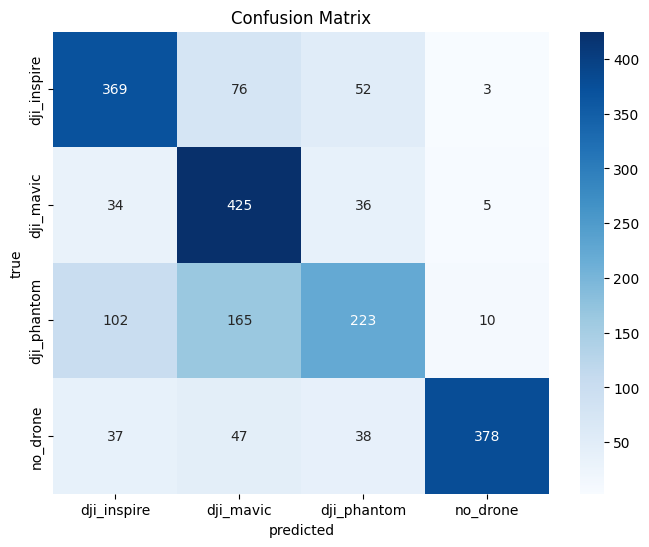

In [55]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('predicted')
plt.ylabel('true')
plt.title('Confusion Matrix')
plt.show()

**strengths:**

- model recognizes 'dji_mavic' class best (425/500 correct - 85%).
- 'dji_inspire' and 'no_drone' - also good (74% and 74%).

**weaknesses:**

most misclassified is 'dji_phantom':
- model often thinks it's 'dji_mavic' (165 times)
- or 'dji_inspire' (102 times)

### random model's predictions

- denormalizing images before output

In [56]:
def denormalize(img_tensor, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return img_tensor * std + mean

In [57]:
def show_pred(model, dataloader, class_names, num_images=6):
    model.eval()
    model.to(device)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    all_images = []
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            for i in range(images.size(0)):
                all_images.append(images[i].cpu())
                all_preds.append(preds[i].item())
                all_labels.append(labels[i].item())

    indices = random.sample(range(len(all_images)), num_images)
    plt.figure(figsize=(15, 8))
    for i, idx in enumerate(indices):
        img = denormalize(all_images[idx], mean, std)
        img = torch.clamp(img, 0, 1).permute(1, 2, 0)
        plt.subplot(2, (num_images + 1) // 2, i + 1)
        plt.imshow(img)
        plt.title(f"Pred: {class_names[all_preds[idx]]}\nTrue: {class_names[all_labels[idx]]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

predicted labels comparing to the true ones:

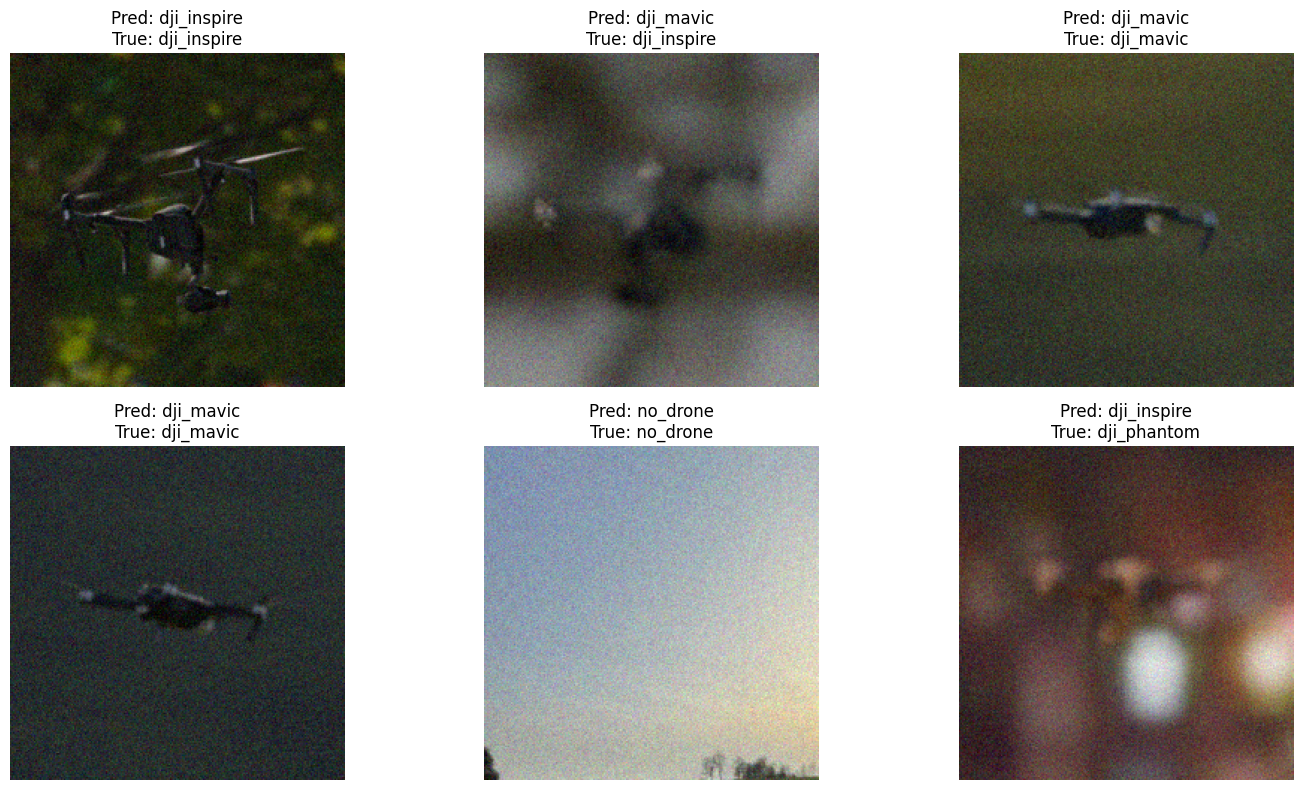

In [58]:
show_pred(model, test_loader, class_names)

### random model's mistakes

In [59]:
def show_misclassified(model, dataloader, class_names, num_images=6):

    model.eval()
    model.to(device)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    misclassified = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            for i in range(images.size(0)):
                if preds[i] != labels[i]:
                    misclassified.append((
                        images[i].cpu(), preds[i].item(), labels[i].item()))

    num_to_show = min(num_images, len(misclassified))
    chosen = random.sample(misclassified, num_to_show)
    plt.figure(figsize=(15, 8))
    for i, (img_tensor, pred, true) in enumerate(chosen):
        img = denormalize(img_tensor, mean, std)
        img = torch.clamp(img, 0, 1).permute(1, 2, 0)
        plt.subplot(2, (num_to_show + 1) // 2, i + 1)
        plt.imshow(img)
        plt.title(f"Pred: {class_names[pred]}\nTrue: {class_names[true]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

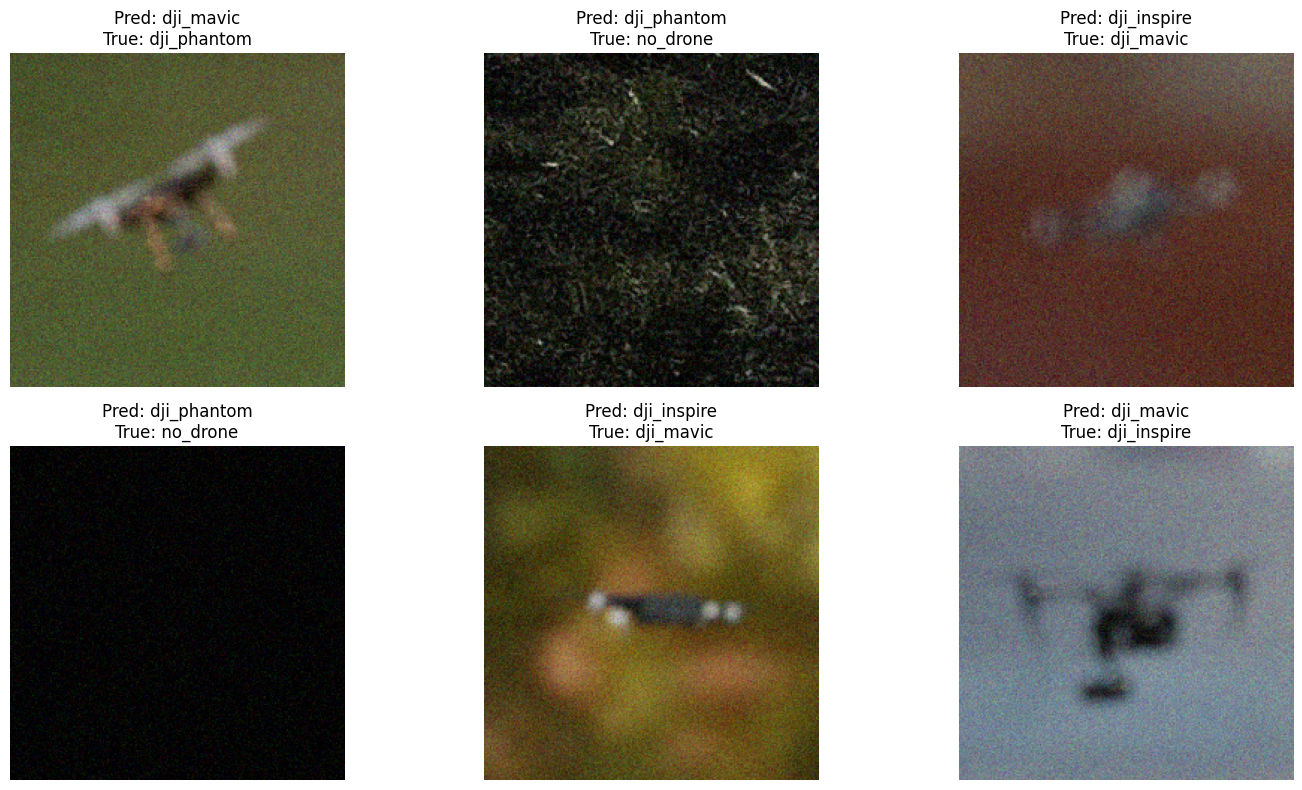

In [60]:
show_misclassified(model, test_loader, class_names)

## conclusions

- test accuracy: 0.7
- model was trained on 40 epochs 
- the worst recognized class: 'dji_phantom'
- layers were unfrozen starting from the 3rd epoch, there are 19 layers in total 
- I trained this model without Gaussian Blur - the accuracy is much higher (accuracy 0.8485 on the 15th epoch)

To sum up, if we train the model without grain - it works much better, but I decided not to remove it, because in real life, there will be no such high-quality image as we have in the validation and test sets. 

If we think about the application of the model in real life, it should be able to work with grainy images, so I think this will be a place for improving the model.